# ADVANCED CLASSIFICATION PREDICT
#### By Dawie Loots

### Honour Code

I, Dawie Loots, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Predict overview</a>

<a href=#two>2. Importing packages</a>

<a href=#three>3. Loading the data</a>

<a href=#four>4. Data Preprocessing</a>

<a href=#five>5. Exploratory Data Analysis</a>

<a href=#six>6. Modeling</a>

<a href=#seven>7. Model performance evaluation</a>

<a href=#eight>8. Model analysis and conclusion</a>

<a id="one"></a>
### 1. Predict overview

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

<a id="two"></a>
### 2. Importing packages

In [ ]:
# Libraries for data loading, data manipulation and data visulisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet # To provide a best estimate of the encoding that was used in the text data
import io # For string operations
%matplotlib inline

# Libraries for data preparation and model building
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import math
import re
from sklearn.utils import resample
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Setting global constants to ensure notebook results are reproducible
PARAMETER_CONSTANT = 42  # This is the seed value for random number generation
# Vectorizer constants
MAX_DF = 0.30
MIN_DF = 2
NGRAM_RANGE = (1,2)
MAX_FEATURES = 2000

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a id="three"></a>
### 3. Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/data/train.csv')
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


<a id="four"></a>
### 4. Data preprocessing

Check for missing values.

In [ ]:
df_train.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

There is no missing data, so let's proceed by checking for class imbalance.

In [ ]:
class_count = df_train['sentiment'].value_counts()
class_count

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

Seems like most of the tweets were for class 1 (supporting the belief of man-made changes)
Let's divide the total 15,819 tweets by 4, to get +- 3,955 per class.  We will need to upsamle classes 0, -1 and 2, and downsample class 1

In [ ]:
class_min1 = df_train[df_train['sentiment']==-1]
class_0 = df_train[df_train['sentiment']==0]
class_1 = df_train[df_train['sentiment']==1]
class_2 = df_train[df_train['sentiment']==2]
balance = len(df_train) // 4 # The number of samples that will result in class balance
df_train_class1_resampled = resample(class_1,
                            replace=False, # sample without replacement (no need to duplicate observations)
                            n_samples=balance, # make all classes equal
                            random_state=27) # reproducible results
df_train_classmin1_resampled = resample(class_min1,
                            replace=True, # sample with replacement (we need to duplicate observations)
                            n_samples=balance, # make all classes equal
                            random_state=27) # reproducible results
df_train_class0_resampled = resample(class_0,
                            replace=True, # sample with replacement (we need to duplicate observations)
                            n_samples=balance, # make all classes equal
                            random_state=27) # reproducible results
df_train_class2_resampled = resample(class_2,
                            replace=True, # sample with replacement (we need to duplicate observations)
                            n_samples=balance, # make all classes equal
                            random_state=27) # reproducible results

df_train.reset_index(drop=True, inplace=True) # Reset index before upsampling
df_train = pd.concat([df_train_class1_resampled, df_train_classmin1_resampled,
                                df_train_class0_resampled, df_train_class2_resampled])
df_train.set_index(df_train.index, inplace=True) # Set the default integer index as the new index after upsampling

# Check new class counts
df_train['sentiment'].value_counts()

 1    3954
-1    3954
 0    3954
 2    3954
Name: sentiment, dtype: int64

Now that we have class balance, let's proceed with the following steps to convert text into numerical values, so that it can be used for this classification task:

- Change column names where required
- Removing noise (such as web-urls)
- Removing punctuation
- Tokenization
- Removal of stop words
- Lemmatization



In [ ]:
# Change column name of "message" - in case it will be a token
def rename_columns(df):
    df = df.rename(columns={'message': 'originaltwittermessage'})
    return df

df_train = rename_columns(df_train)
df_train.head()

,sentiment,originaltwittermessage,tweetid
11729,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844
8308,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956
7159,1,RT @pattonoswalt: Not ominous at all! (He also...,978938
5644,1,RT @MelissaJPeltier: In case you forgot about ...,587737
6732,1,RT @SethMacFarlane: HRC proposes installing ha...,804767


In [ ]:
# Remove noise (all hyperlinks)

def remove_noise(df):
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'   # Find all hyperlinks
    subs_url = r''
    df['originaltwittermessage'] = df['originaltwittermessage'].replace(to_replace = pattern_url, value = subs_url, regex = True)
    return df

remove_noise(df_train)
df_train.head()

,sentiment,originaltwittermessage,tweetid
11729,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844
8308,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956
7159,1,RT @pattonoswalt: Not ominous at all! (He also...,978938
5644,1,RT @MelissaJPeltier: In case you forgot about ...,587737
6732,1,RT @SethMacFarlane: HRC proposes installing ha...,804767


In [ ]:
# Handle emoticons
def process_emoticons(df):
    emoticon_dictionary = {':\)': 'smiley_face_emoticon',
                           ':\(': 'frowning_face_emoticon',
                           ':D': 'grinning_face_emoticon',
                           ':P': 'sticking_out_tongue_emoticon',
                           ';\)': 'winking_face_emoticon',
                           ':o': 'surprised_face_emoticon',
                           ':\|': 'neutral_face_emoticon',
                           ':\'\)': 'tears_of_joy_emoticon',
                           ':\'\(': 'crying_face_emoticon'}

    df['message_encoded_emojis'] = df['originaltwittermessage'].replace(emoticon_dictionary, regex=True)
    return df

process_emoticons(df_train)
# Check if it was correctly
emoji_rows = df_train[df_train['originaltwittermessage'].str.contains(':\(')]
emoji_rows.head(10)

,sentiment,originaltwittermessage,tweetid,message_encoded_emojis
2549,1,RT @Greenpeace: Sad :( Animals and birds which...,909808,RT @Greenpeace: Sad frowning_face_emoticon Ani...
4687,1,@timesofindia why do fishermen always fish muc...,855852,@timesofindia why do fishermen always fish muc...
11386,1,"RT @savitriyaca: a must watch, cause climate c...",891447,"RT @savitriyaca: a must watch, cause climate c..."
11203,1,@trees_r_cool animal agriculture is the main c...,164712,@trees_r_cool animal agriculture is the main c...
15225,1,@KamalaHarris Start with a Pareto of biggest c...,307036,@KamalaHarris Start with a Pareto of biggest c...
1038,1,Whenever it randomly snows like this I get v w...,166148,Whenever it randomly snows like this I get v w...
5200,0,EPA head Scott Pruitt denies that carbon dioxi...,152968,EPA head Scott Pruitt denies that carbon dioxi...
5200,0,EPA head Scott Pruitt denies that carbon dioxi...,152968,EPA head Scott Pruitt denies that carbon dioxi...


In [ ]:
# Remove punctuation and expand all contracted words
def remove_punctuation(message):
    contractions = {"'t": " not","'s": " is","'re": " are","'ll": " will", "'m": " am"}
    pattern = re.compile(r"\b(" + "|".join(re.escape(key) for key in contractions.keys()) + r")\b")
    message = re.sub(r"n't\b", " not", message) # Replace "n't" with " not"
    message = pattern.sub(lambda match: contractions[match.group(0)], message) # Replace all other contractions except for "n't"
    return ''.join([l for l in message if l not in string.punctuation])

df_train['message_clean'] = df_train['message_encoded_emojis'].apply(remove_punctuation)
df_train.head()

,sentiment,originaltwittermessage,tweetid,message_encoded_emojis,message_clean
11729,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844,RT @ubcforestry: Funding from @GenomeBC will s...,RT ubcforestry Funding from GenomeBC will supp...
8308,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956,@YadiMoIina gag orders? Sure. He's definitely ...,YadiMoIina gag orders Sure He is definitely gr...
7159,1,RT @pattonoswalt: Not ominous at all! (He also...,978938,RT @pattonoswalt: Not ominous at all! (He also...,RT pattonoswalt Not ominous at all He also wan...
5644,1,RT @MelissaJPeltier: In case you forgot about ...,587737,RT @MelissaJPeltier: In case you forgot about ...,RT MelissaJPeltier In case you forgot about th...
6732,1,RT @SethMacFarlane: HRC proposes installing ha...,804767,RT @SethMacFarlane: HRC proposes installing ha...,RT SethMacFarlane HRC proposes installing half...


In [ ]:
# Tokenization
def tokenize(df):
    tokenizer = TweetTokenizer()
    df['tokens'] = df['message_clean'].apply(tokenizer.tokenize)
    return df

tokenize(df_train)

,sentiment,originaltwittermessage,tweetid,message_encoded_emojis,message_clean,tokens
11729,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844,RT @ubcforestry: Funding from @GenomeBC will s...,RT ubcforestry Funding from GenomeBC will supp...,"[RT, ubcforestry, Funding, from, GenomeBC, wil..."
8308,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956,@YadiMoIina gag orders? Sure. He's definitely ...,YadiMoIina gag orders Sure He is definitely gr...,"[YadiMoIina, gag, orders, Sure, He, is, defini..."
7159,1,RT @pattonoswalt: Not ominous at all! (He also...,978938,RT @pattonoswalt: Not ominous at all! (He also...,RT pattonoswalt Not ominous at all He also wan...,"[RT, pattonoswalt, Not, ominous, at, all, He, ..."
5644,1,RT @MelissaJPeltier: In case you forgot about ...,587737,RT @MelissaJPeltier: In case you forgot about ...,RT MelissaJPeltier In case you forgot about th...,"[RT, MelissaJPeltier, In, case, you, forgot, a..."
6732,1,RT @SethMacFarlane: HRC proposes installing ha...,804767,RT @SethMacFarlane: HRC proposes installing ha...,RT SethMacFarlane HRC proposes installing half...,"[RT, SethMacFarlane, HRC, proposes, installing..."
...,...,...,...,...,...,...
12292,2,Video: Statoil produces climate change 'roadma...,633554,Video: Statoil produces climate change 'roadma...,Video Statoil produces climate change roadmap ...,"[Video, Statoil, produces, climate, change, ro..."
15209,2,"RT @Reuters: In rare move, China criticizes Tr...",724243,"RT @Reuters: In rare move, China criticizes Tr...",RT Reuters In rare move China criticizes Trump...,"[RT, Reuters, In, rare, move, China, criticize..."
7757,2,RT @DonaldMacDona18: Global climate change bat...,878987,RT @DonaldMacDona18: Global climate change bat...,RT DonaldMacDona18 Global climate change battl...,"[RT, DonaldMacDona, 18, Global, climate, chang..."
5707,2,RT @BBCBreaking: UK government signs Paris Agr...,151024,RT @BBCBreaking: UK government signs Paris Agr...,RT BBCBreaking UK government signs Paris Agree...,"[RT, BBCBreaking, UK, government, signs, Paris..."


In [ ]:
# Remove stopwords
def remove_stop_words(df):
    stop_words = set(stopwords.words('english'))
    # Remove stopwords using a vectorized operation
    df['tokens_without_stopwords'] = df['tokens'].apply(lambda tokens: [t for t in tokens if t.lower() not in stop_words])
    return df

remove_stop_words(df_train)
df_train.head()

,sentiment,originaltwittermessage,tweetid,message_encoded_emojis,message_clean,tokens,tokens_without_stopwords
11729,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844,RT @ubcforestry: Funding from @GenomeBC will s...,RT ubcforestry Funding from GenomeBC will supp...,"[RT, ubcforestry, Funding, from, GenomeBC, wil...","[RT, ubcforestry, Funding, GenomeBC, support, ..."
8308,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956,@YadiMoIina gag orders? Sure. He's definitely ...,YadiMoIina gag orders Sure He is definitely gr...,"[YadiMoIina, gag, orders, Sure, He, is, defini...","[YadiMoIina, gag, orders, Sure, definitely, gr..."
7159,1,RT @pattonoswalt: Not ominous at all! (He also...,978938,RT @pattonoswalt: Not ominous at all! (He also...,RT pattonoswalt Not ominous at all He also wan...,"[RT, pattonoswalt, Not, ominous, at, all, He, ...","[RT, pattonoswalt, ominous, also, wants, names..."
5644,1,RT @MelissaJPeltier: In case you forgot about ...,587737,RT @MelissaJPeltier: In case you forgot about ...,RT MelissaJPeltier In case you forgot about th...,"[RT, MelissaJPeltier, In, case, you, forgot, a...","[RT, MelissaJPeltier, case, forgot, Chinese, H..."
6732,1,RT @SethMacFarlane: HRC proposes installing ha...,804767,RT @SethMacFarlane: HRC proposes installing ha...,RT SethMacFarlane HRC proposes installing half...,"[RT, SethMacFarlane, HRC, proposes, installing...","[RT, SethMacFarlane, HRC, proposes, installing..."


In [ ]:
# Lemmatization
def lemmatize(words, lemmatizer):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word.lower(), pos='v') for word in words]
lemmatizer = WordNetLemmatizer()
df_train['lemma'] = df_train['tokens_without_stopwords'].apply(lemmatize, args=(lemmatizer, ))
df_train.head()

,sentiment,originaltwittermessage,tweetid,message_encoded_emojis,message_clean,tokens,tokens_without_stopwords,lemma
11729,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844,RT @ubcforestry: Funding from @GenomeBC will s...,RT ubcforestry Funding from GenomeBC will supp...,"[RT, ubcforestry, Funding, from, GenomeBC, wil...","[RT, ubcforestry, Funding, GenomeBC, support, ...","[rt, ubcforestry, fund, genomebc, support, sal..."
8308,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956,@YadiMoIina gag orders? Sure. He's definitely ...,YadiMoIina gag orders Sure He is definitely gr...,"[YadiMoIina, gag, orders, Sure, He, is, defini...","[YadiMoIina, gag, orders, Sure, definitely, gr...","[yadimoiina, gag, order, sure, definitely, gre..."
7159,1,RT @pattonoswalt: Not ominous at all! (He also...,978938,RT @pattonoswalt: Not ominous at all! (He also...,RT pattonoswalt Not ominous at all He also wan...,"[RT, pattonoswalt, Not, ominous, at, all, He, ...","[RT, pattonoswalt, ominous, also, wants, names...","[rt, pattonoswalt, ominous, also, want, name, ..."
5644,1,RT @MelissaJPeltier: In case you forgot about ...,587737,RT @MelissaJPeltier: In case you forgot about ...,RT MelissaJPeltier In case you forgot about th...,"[RT, MelissaJPeltier, In, case, you, forgot, a...","[RT, MelissaJPeltier, case, forgot, Chinese, H...","[rt, melissajpeltier, case, forget, chinese, h..."
6732,1,RT @SethMacFarlane: HRC proposes installing ha...,804767,RT @SethMacFarlane: HRC proposes installing ha...,RT SethMacFarlane HRC proposes installing half...,"[RT, SethMacFarlane, HRC, proposes, installing...","[RT, SethMacFarlane, HRC, proposes, installing...","[rt, sethmacfarlane, hrc, propose, instal, hal..."


<a id="five"></a>
### 5. Exploratory Data Analysis

# Convert into Bag Of Words using CountVectorizer
def vectorize(df, max_df, min_df, ngram_range, max_features):
    # Flatten the list of lists into a single list of strings
    df['flattened_lemma'] = df['lemma'].apply(lambda word_list: ' '.join(word_list))
    # Create and fit the CountVectorizer
    vect = CountVectorizer(lowercase=True, max_df=max_df, min_df=min_df, ngram_range=ngram_range,
                           max_features=max_features)
    vect.fit(df_train['flattened_lemma'])  # Note that the vectorizer is always fit on the train data, so that both
                                           # train and test sets are vectorized on the same vocabulary
    X = vect.transform(df['flattened_lemma'])
    bag_of_words = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
    # Merge original dataset with Bag Of Words
    bag_of_words.reset_index(drop=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    vectorized_df = pd.concat([bag_of_words, df],axis=1)
    return vectorized_df

df_train = vectorize(df_train, MAX_DF, MIN_DF, NGRAM_RANGE, MAX_FEATURES)
df_train.head()

In [ ]:
# Convert into Bag Of Words using TF-IDF vectorizer
def fit_vectorizer(df, max_df, min_df, ngram_range, max_features):
    # Flatten the list of lists into a single list of strings
    df['flattened_lemma'] = df['lemma'].apply(lambda word_list: ' '.join(word_list))
    # Create and fit the CountVectorizer
    vect = TfidfVectorizer(max_features=max_features, lowercase=True,max_df=max_df,min_df=min_df,ngram_range=ngram_range)
    vect.fit(df['flattened_lemma'])  # Note that the vectorizer is always fit on the train data, so that both
                                           # train and test sets are vectorized on the same vocabulary
    return vect

def transform_into_bagofwords(df, fitted_vectorizer):
    df['flattened_lemma'] = df['lemma'].apply(lambda word_list: ' '.join(word_list))
    X = fitted_vectorizer.transform(df['flattened_lemma'])
    bag_of_words = pd.DataFrame(X.toarray(), columns=fitted_vectorizer.get_feature_names_out())
    # Merge original dataset with Bag Of Words
    bag_of_words.reset_index(drop=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    vectorized_df = pd.concat([bag_of_words, df],axis=1)
    return vectorized_df

vectorizer_train = fit_vectorizer(df_train, MAX_DF, MIN_DF, NGRAM_RANGE, MAX_FEATURES)
df_train = transform_into_bagofwords(df_train, vectorizer_train)
df_train.head()

,10,100,11,12,123,13,15,15 trillion,16,17,...,ëœâ,sentiment,originaltwittermessage,tweetid,message_encoded_emojis,message_clean,tokens,tokens_without_stopwords,lemma,flattened_lemma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844,RT @ubcforestry: Funding from @GenomeBC will s...,RT ubcforestry Funding from GenomeBC will supp...,"[RT, ubcforestry, Funding, from, GenomeBC, wil...","[RT, ubcforestry, Funding, GenomeBC, support, ...","[rt, ubcforestry, fund, genomebc, support, sal...",rt ubcforestry fund genomebc support sallynait...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956,@YadiMoIina gag orders? Sure. He's definitely ...,YadiMoIina gag orders Sure He is definitely gr...,"[YadiMoIina, gag, orders, Sure, He, is, defini...","[YadiMoIina, gag, orders, Sure, definitely, gr...","[yadimoiina, gag, order, sure, definitely, gre...",yadimoiina gag order sure definitely green thi...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,RT @pattonoswalt: Not ominous at all! (He also...,978938,RT @pattonoswalt: Not ominous at all! (He also...,RT pattonoswalt Not ominous at all He also wan...,"[RT, pattonoswalt, Not, ominous, at, all, He, ...","[RT, pattonoswalt, ominous, also, wants, names...","[rt, pattonoswalt, ominous, also, want, name, ...",rt pattonoswalt ominous also want name anyone ...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,RT @MelissaJPeltier: In case you forgot about ...,587737,RT @MelissaJPeltier: In case you forgot about ...,RT MelissaJPeltier In case you forgot about th...,"[RT, MelissaJPeltier, In, case, you, forgot, a...","[RT, MelissaJPeltier, case, forgot, Chinese, H...","[rt, melissajpeltier, case, forget, chinese, h...",rt melissajpeltier case forget chinese hoax gl...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,RT @SethMacFarlane: HRC proposes installing ha...,804767,RT @SethMacFarlane: HRC proposes installing ha...,RT SethMacFarlane HRC proposes installing half...,"[RT, SethMacFarlane, HRC, proposes, installing...","[RT, SethMacFarlane, HRC, proposes, installing...","[rt, sethmacfarlane, hrc, propose, instal, hal...",rt sethmacfarlane hrc propose instal half bill...


# Convert into numbers using Word2Vec
def word_to_vec(df, vector_size, window, min_count, sg):
  word2vec_model = Word2Vec(sentences=df['lemma'], vector_size=vector_size, window=window, min_count=min_count, sg=sg)
  df['vector'] = df['flattened_lemma'].apply(lambda x: np.mean([word2vec_model.wv[word] for word in x if word in word2vec_model.wv], axis=0))
  return df

df_train = word_to_vec(df_train, 100, 5, 1, 1)

grouped = df_train.groupby('sentiment').sum()
top_n = 10
top_words_per_class = {}
for class_name, row in grouped.iterrows():
    top_words = row.sort_values(ascending=False)[:top_n]
    top_words_per_class[class_name] = top_words

# Create bar plots for top 10 words per class
for class_name, top_words in top_words_per_class.items():
    plt.figure(figsize=(10, 6))
    top_words.plot(kind='bar', color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words in {class_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Get the indices of features sorted by their TF-IDF scores
X = df_train.copy()
y = df_train.sentiment
columns_to_drop = ['sentiment','message','tweetid','message_encoded_emojis','message_clean','tokens','tokens_without_stopwords','lemma','flattened_lemma']
X.drop(columns=columns_to_drop,inplace=True)
top_indices = X.sum(axis=0).values.argsort()[::-1]

# Get the feature names from the vectorizer
feature_names = np.array(X.columns)

# Print the top 20 words/n-grams based on TF-IDF scores
unique_classes = np.unique(y)
for class_label in unique_classes:
    print(f"Top 20 words/n-grams for class {class_label}:")
    # Get indices of documents belonging to the current class
    class_indices = np.where(y == class_label)[0]
    # Calculate mean TF-IDF scores for each feature across documents in the class
    mean_tfidf_scores = X.iloc[class_indices].mean(axis=0)
    # Get the top indices based on mean TF-IDF scores
    top_indices = mean_tfidf_scores.argsort()[::-1][:20]
    # Print top features
    for i, index in enumerate(top_indices):
        print(f"{i+1}. {feature_names[index]}")
    print()

Top 20 words/n-grams for class -1:
1. warm - Frequency: 259
2. global warm - Frequency: 255
3. make - Frequency: 76
4. science - Frequency: 62
5. amp - Frequency: 58
6. hoax - Frequency: 55
7. cause - Frequency: 53
8. scam - Frequency: 52
9. real - Frequency: 52
10. man - Frequency: 51
11. realdonaldtrump - Frequency: 50
12. manmade - Frequency: 50
13. stevesgoddard - Frequency: 46
14. go - Frequency: 46
15. believe - Frequency: 45
16. fake - Frequency: 42
17. say - Frequency: 41
18. get - Frequency: 40
19. leave - Frequency: 40
20. man make - Frequency: 40

Top 20 words/n-grams for class 0:
1. warm - Frequency: 340
2. global warm - Frequency: 339
3. say - Frequency: 56
4. cause - Frequency: 55
5. believe - Frequency: 52
6. trump - Frequency: 52
7. like - Frequency: 52
8. think - Frequency: 51
9. amp - Frequency: 45
10. know - Frequency: 42
11. penguin - Frequency: 41
12. get - Frequency: 40
13. real - Frequency: 40
14. us - Frequency: 38
15. ask - Frequency: 37
16. people - Frequency:

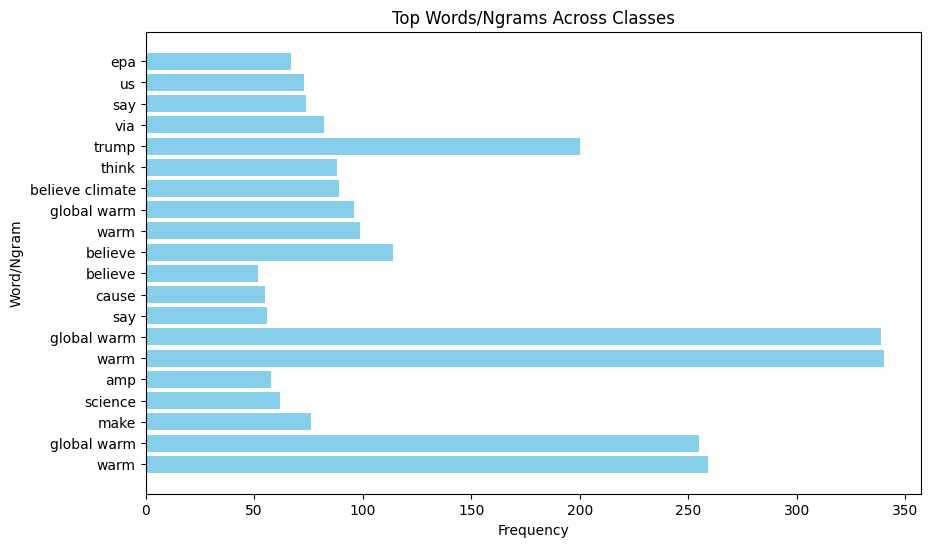

In [ ]:
# Get the indices of features sorted by their TF-IDF scores
X = df_train.copy()
y = df_train.sentiment
columns_to_drop = ['sentiment','originaltwittermessage','tweetid','message_encoded_emojis','message_clean','tokens','tokens_without_stopwords','lemma','flattened_lemma']
X.drop(columns=columns_to_drop, inplace=True)

# Get the feature names from the DataFrame
feature_names = np.array(X.columns)

# Initialize an empty dictionary to store the frequency of each word/ngram for each class
word_freq_per_class = {class_label: {} for class_label in np.unique(y)}

# Calculate the frequency of each word/ngram for each class
for class_label in np.unique(y):
    class_indices = np.where(y == class_label)[0]
    class_data = X.iloc[class_indices]
    class_word_freq = class_data.sum(axis=0).astype(int)
    word_freq_per_class[class_label] = class_word_freq

# Print the top 20 words/ngrams based on TF-IDF scores for each class
for class_label in np.unique(y):
    print(f"Top 20 words/n-grams for class {class_label}:")
    class_word_freq = word_freq_per_class[class_label]
    top_indices = class_word_freq.argsort()[::-1][:20]
    for i, index in enumerate(top_indices):
        print(f"{i+1}. {feature_names[index]} - Frequency: {class_word_freq[index]}")
    print()

# Visualizations
# Bar plot to compare the top words/ngrams across classes
top_words = []
class_labels = []
word_freqs = []

for class_label, class_word_freq in word_freq_per_class.items():
    top_indices = class_word_freq.argsort()[::-1][:5]  # Select top 5 words/ngrams
    top_words.extend(feature_names[top_indices])
    class_labels.extend([class_label] * len(top_indices))
    word_freqs.extend(class_word_freq[top_indices])

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_words)), word_freqs, color='skyblue')
plt.yticks(range(len(top_words)), top_words)
plt.xlabel('Frequency')
plt.ylabel('Word/Ngram')
plt.title('Top Words/Ngrams Across Classes')
plt.show()


def feature_selection_kbest(df):
    X = df.copy()
    y = X.sentiment
    columns_to_drop = X.select_dtypes(include=['object']).columns
    columns_to_drop = list(columns_to_drop) + ['tweetid', 'sentiment']
    X.drop(columns=columns_to_drop,inplace=True)
    # Reduce features
    kbest = LogisticRegression()
    # Set up selector, choosing score function and number of features to retain
    selector_kbest = SelectKBest(score_func=f_classif, k=50)
    selector_kbest.fit(X, y)
    selected_feature_names = X.columns[selector_kbest.get_support()]
    return selected_feature_names

feature_names = feature_selection_kbest(df_train)

In [ ]:
# Drop all text columns
def drop_unnecessary_col(df):
    columns_to_drop = df.select_dtypes(include=['object']).columns
    columns_to_drop = list(columns_to_drop) + ['tweetid']
    df.drop(columns=columns_to_drop,inplace=True)
    return df

df_train = drop_unnecessary_col(df_train)
df_train.head()

,10,100,11,12,123,13,15,15 trillion,16,17,...,yet,york,young,youth,youtube,yrs,zero,zone,ëœâ,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
# Scale the features
def scale_features(df):
  scaler = StandardScaler()
  y = df.sentiment
  X = df.drop(columns=['sentiment'])
  X_scaled = scaler.fit_transform(X)
  X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
  scaled_df = pd.concat([X_scaled_df, y], axis=1)
  return scaled_df

df_train = scale_features(df_train)
df_train.head()


,10,100,11,12,123,13,15,15 trillion,16,17,...,yet,york,young,youth,youtube,yrs,zero,zone,ëœâ,sentiment
0,-0.052034,-0.06262,-0.050406,-0.049874,-0.057554,-0.040982,-0.057932,-0.035186,-0.034023,-0.04882,...,-0.062578,-0.056866,-0.037415,-0.030502,-0.046837,-0.029643,-0.037827,-0.034254,-0.048724,1
1,-0.052034,-0.06262,-0.050406,-0.049874,-0.057554,-0.040982,-0.057932,-0.035186,-0.034023,-0.04882,...,-0.062578,-0.056866,-0.037415,-0.030502,-0.046837,-0.029643,-0.037827,-0.034254,-0.048724,1
2,-0.052034,-0.06262,-0.050406,-0.049874,-0.057554,-0.040982,-0.057932,-0.035186,-0.034023,-0.04882,...,-0.062578,-0.056866,-0.037415,-0.030502,-0.046837,-0.029643,-0.037827,-0.034254,-0.048724,1
3,-0.052034,-0.06262,-0.050406,-0.049874,-0.057554,-0.040982,-0.057932,-0.035186,-0.034023,-0.04882,...,-0.062578,-0.056866,-0.037415,-0.030502,-0.046837,-0.029643,-0.037827,-0.034254,-0.048724,1
4,-0.052034,-0.06262,-0.050406,-0.049874,-0.057554,-0.040982,-0.057932,-0.035186,-0.034023,-0.04882,...,-0.062578,-0.056866,-0.037415,-0.030502,-0.046837,-0.029643,-0.037827,-0.034254,-0.048724,1


In [ ]:
# Split into training and test data
def split_train_test(df, feature_names):
    X = df[feature_names].copy()
    y = df.sentiment
    X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.15, random_state=42,stratify=y)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test(df_train, feature_names)

# Split into training and test data, but with a smaller dataset
X = df_train.drop(columns=['sentiment']).copy()
y = df_train.sentiment.copy()
sample_size = int(len(X) * 0.33)  
# Perform stratified sampling on a smaller subset of the data
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample.values, test_size=0.15, random_state=42,stratify=y_sample)


In [ ]:
mutual_info_scores = mutual_info_classif(X_train, y_train)
top_indices = (-mutual_info_scores).argsort()[:1000]
feature_names = X_train.columns[top_indices]
X_train = X_train[feature_names]
X_test = X_test[feature_names]

<a id="six"></a>
### 6. Modelling

In [ ]:
# Define all the classifiers
names = [
         #'Logistic Regression',
         #'Nearest Neighbors',
         #'Linear SVM',
         'RBF SVM',
         #'Decision Tree',
         #'Random Forest',
         #'AdaBoost',
         #'Gaussian Naive Bayes',
         #'Multinomial Naive Bayes',
         #'XGBoost'
         ]

classifiers = [
               #LogisticRegression(max_iter=1000),
               #KNeighborsClassifier(n_neighbors=3), #algorithm='ball_tree', leaf_size=30, metric='minkowski',
                                    # p=2, weights='distance'),
               #SVC(kernel="linear", C=0.025),
               SVC(gamma=1, C=1),
               #DecisionTreeClassifier(max_depth=5),
               #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
               #AdaBoostClassifier(random_state=42, n_estimators=200),
               #GaussianNB(),
               #MultinomialNB(alpha=0.05),
               #xgb.XGBClassifier(objective='multi:softmax', max_depth=10, num_class=len(set(y_train)))
              ]

param_grids = [
               #{}, #Logistic Regression
               #{'n_neighbors': [2,3], 'metric': ['minkowski', 'euclidean', 'manhattan', 'hamming', 'cosine', 'correlation','jaccard'],
               # 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
               # 'leaf_size': [30,50], 'p': [1, 2]}, #Nearest Neighbors
               #{}, #Linear SVM
               {'kernel': ['rbf'],'gamma': (0.001,0.01,1),'C': (0.1,1,10), 'class_weight': [None, 'balanced'],'probability': [True, False],
                'shrinking': [True, False], 'tol': [1e-3, 1e-4] } #RBF SVM
               #{}, #Decision Tree
               #{'max_depth': [2,5,10], 'n_estimators': [50,100,250], 'random_state': [42]}, #Random Forest
               #{'random_state': [42], 'n_estimators': [50,100,200], 'learning_rate': [0.1, 1, 2]}, #Adaboost
               #{}, #Gaussian Naive Bayes
               #{'alpha': [0.05, 0.1, 0.5, 1]}, #Multinomial Naive Bayes
               #{}, #XGBoost
              ]


In [ ]:
# Train all the models

results = []
models = {}
confusion = {}
class_report = {}

for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)

    print ('... predicting')
    y_pred = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='weighted')
    recall    = metrics.recall_score(y_train, y_pred, average='weighted')

    f1        = metrics.f1_score(y_train, y_pred, average='weighted')
    f1_test   = metrics.f1_score(y_test, y_pred_test, average='weighted')

    # Save the results to dictionaries
    models[name] = clf
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)

    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])


results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting RBF SVM model...
... predicting
... scoring
... All done!


In [ ]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
RBF SVM,0.981849,0.982207,0.981849,0.981923,0.841418,175.160456


<Axes: xlabel='Classifier'>

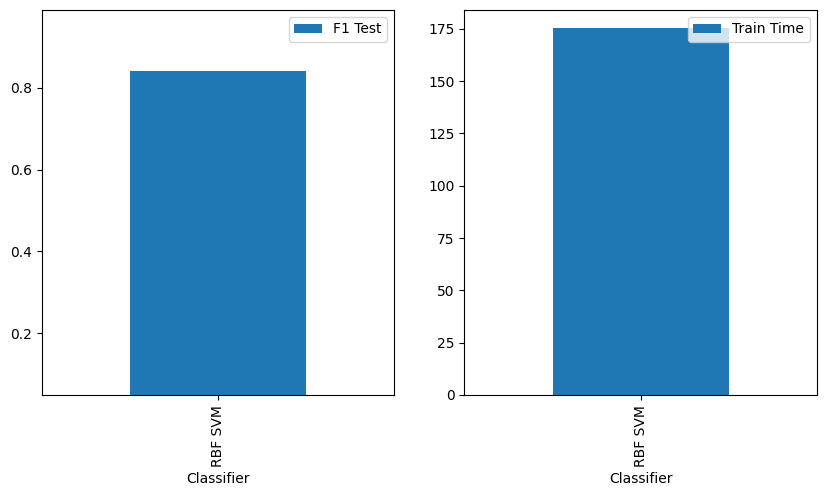

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.05,0.99])
results.plot(y='Train Time', kind='bar', ax=ax[1])

<a id="seven"></a>
### 7. Model performance evaluation


RBF SVM
Accuracy: 0.80 (+/- 0.0038)


<Axes: xlabel='Model'>

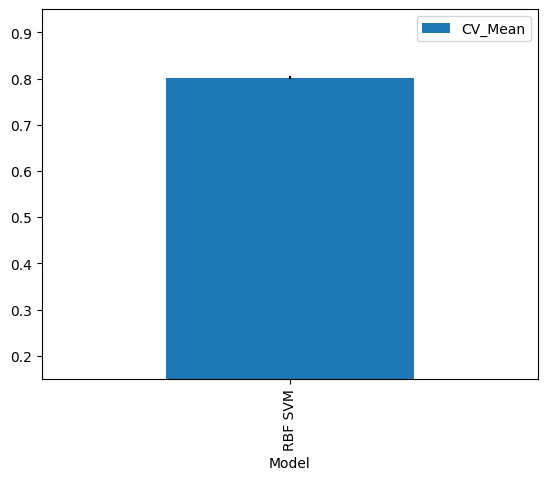

In [ ]:
# Use K-Fold cross validation
cv = []
for name, model in models.items():
    print ()
    print(name)
    scores = cross_val_score(model, X=X_train, y=y_train, cv=5)
    print("Accuracy: {:0.2f} (+/- {:0.4f})".format(scores.mean(), scores.std()))
    cv.append([name, scores.mean(), scores.std() ])

cv = pd.DataFrame(cv, columns=['Model', 'CV_Mean', 'CV_Std_Dev'])
cv.set_index('Model', inplace=True)

cv.plot(y='CV_Mean', yerr='CV_Std_Dev',kind='bar', ylim=[0.15, 0.95])

# Manual KNN hyperparameters

ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]

results = []

for k in ks:
    print('Fitting KNN model with k = {:d}'.format(k))
    knn = KNeighborsClassifier(k)
    run_time = %timeit -q -o knn.fit(X_train, y_train)

    # predicting
    y_pred = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)

    # scoring
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='weighted')
    recall    = metrics.recall_score(y_train, y_pred, average='weighted')
    f1        = metrics.f1_score(y_train, y_pred, average='weighted')
    f1_test   = metrics.f1_score(y_test, y_pred_test, average='weighted')

    # save the results
    results.append([k, accuracy, precision, recall, f1, f1_test, run_time.best])

results = pd.DataFrame(results, columns=['KNN', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('KNN', inplace= True)
results

<a id="eight"></a>
### 8. Hyperparameter tuning

# GridSearchCV

for classifier, params in zip(classifiers, param_grids):
    model = classifier
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    clf = GridSearchCV(model, params, scoring='f1_macro', cv=skf)
    clf.fit(X_train, y_train)
    print(f'{model} params:           {clf.best_params_}')
    print(f'{model} score:           {clf.best_score_}')
    print('--------------------------------------------------------------------')

### 9. Final model training with best hyperparameters

In [ ]:
#final_model = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
#                                    n_neighbors=3, p=2, weights='distance')
#final_model = MultinomialNB(alpha=0.05)
final_model = SVC(gamma=1, C=1)
final_model.fit(X_train, y_train)

SVC(C=1, gamma=1)

## Process test data

In [ ]:
df_test.head()

,originaltwittermessage,tweetid,message_encoded_emojis,message_clean,tokens,tokens_without_stopwords,lemma,flattened_lemma
0,Europe will now be looking to China to make su...,169760,Europe will now be looking to China to make su...,Europe will now be looking to China to make su...,"[Europe, will, now, be, looking, to, China, to...","[Europe, looking, China, make, sure, alone, fi...","[europe, look, china, make, sure, alone, fight...",europe look china make sure alone fight climat...
1,Combine this with the polling of staffers re c...,35326,Combine this with the polling of staffers re c...,Combine this with the polling of staffers re c...,"[Combine, this, with, the, polling, of, staffe...","[Combine, polling, staffers, climate, change, ...","[combine, poll, staffers, climate, change, wom...",combine poll staffers climate change womens ri...
2,"The scary, unimpeachable evidence that climate...",224985,"The scary, unimpeachable evidence that climate...",The scary unimpeachable evidence that climate ...,"[The, scary, unimpeachable, evidence, that, cl...","[scary, unimpeachable, evidence, climate, chan...","[scary, unimpeachable, evidence, climate, chan...",scary unimpeachable evidence climate change al...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,Karoli morgfair OsborneInk dailykos \nPutin go...,"[Karoli, morgfair, OsborneInk, dailykos, Putin...","[Karoli, morgfair, OsborneInk, dailykos, Putin...","[karoli, morgfair, osborneink, dailykos, putin...",karoli morgfair osborneink dailykos putin get ...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,RT @FakeWillMoore: 'Female orgasms cause globa...,RT FakeWillMoore Female orgasms cause global w...,"[RT, FakeWillMoore, Female, orgasms, cause, gl...","[RT, FakeWillMoore, Female, orgasms, cause, gl...","[rt, fakewillmoore, female, orgasms, cause, gl...",rt fakewillmoore female orgasms cause global w...


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/data/test_with_no_labels.csv')
df_test = rename_columns(df_test)
remove_noise(df_test)
process_emoticons(df_test)
df_test['message_clean'] = df_test['message_encoded_emojis'].apply(remove_punctuation)
tokenize(df_test)
remove_stop_words(df_test)
df_test['lemma'] = df_test['tokens_without_stopwords'].apply(lemmatize, args=(lemmatizer, ))
df_test = transform_into_bagofwords(df_test, vectorizer_train)
df_test = drop_unnecessary_col(df_test)
# Scale features
scaler = StandardScaler()
X = df_test.copy()
X_scaled = scaler.fit_transform(X)
df_test = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
# Make predictions on test data
X = df_test[feature_names].copy()
#X = df_test.copy() # Remove comments if not using kbest (ie other feature selection methods)
#X.drop(columns=columns_to_drop,inplace=True) # Remove comments if not using kbest (ie other feature selection methods)
y_pred = final_model.predict(X)

In [52]:
y_pred.shape

(10546,)

In [55]:
# Create the prediction upload file ⏏
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'/content/drive/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/notebook/dawieloots_predict_{timestamp}.csv'
submission_df = pd.DataFrame()
df_test = pd.read_csv('/content/drive/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/data/test_with_no_labels.csv')
submission_df['tweetid'] = df_test.tweetid
submission_df['sentiment'] = y_pred
submission_df.to_csv(filename, index=False)